In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_6k_collection,
                          load_isoform_and_paralog_y2h_data,
                          load_valid_isoform_clones)

In [82]:
m1h = load_m1h_activation_data()
tfs = load_annotated_6k_collection()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)

# TODO move to data_loading.py
df = pd.read_csv("../output/TF-iso_ref-vs-alt.tsv", sep="\t")

# RORC-1 alt iso is causing an error - filter out here - there's no data for it?
df = df[df["clone_acc_alt"] != "RORC|1/6|05F11"]

df['ref_iso'] = df['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['alt_iso'] = df['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['f_disorder_difference'] = df.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)


def disorder_changes_category(f):
    if pd.isnull(f):
        return np.nan
    elif f == 0:
        return 'fully ordered'
    elif f == 1:
        return 'fully disordered'
    elif f > 0 and f < 1:
        return 'partially disordered'
    else:
        raise ValueError('Invalid fraction')


df['f_disorder_difference_cat'] = df['f_disorder_difference'].apply(disorder_changes_category)
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
df['m1h_gte_2_fold_at_least_one_iso_per_gene'] = df['gene_symbol'].map(m1h.groupby('gene')
                                                                    ['gte_2_fold']
                                                                    .any())
df['abs_activation_fold_change_log2'] = df['activation_fold_change_log2'].abs()

dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])

# add activation or repression
effector_domain_type = {}
for tf in tfs.values():
    for d in tf.cloned_reference_isoform.aa_seq_features:
        if d.category == 'effector_domain':
            effector_domain_type[d.accession] = d.name
dom['type'] = dom['accession'].map(effector_domain_type)


# considering EFFECTOR DOMAINS ONLY
def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()

def domain_length(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['length'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    df['fraction_of_{}_domains_removed'.format(effector_type)] = df.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    df['insertion_in_{}_domains'.format(effector_type)] = df.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)
    df['length_of_{}_domains'.format(effector_type)] = df.apply(domain_length, effector_type=effector_type, axis=1)

reading from cache


In [83]:
# now add Pfam AD/RDs
pfam = pd.read_csv('../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])
# AD
pfam_ad = pfam[(pfam['name'].str.contains("transcription activation")) | 
               (pfam['name'].str.contains("transactivation")) |
               (pfam['short_name'].str.contains("TAD"))].copy()
pfam_ad["type"] = "AD"

# RD
pfam_rd = pfam[(pfam['short_name'].str.contains("NRIP1_repr")) | 
               (pfam['name'].str.contains("KRAB"))].copy()
pfam_rd["type"] = "RD"
pfam_effs = pd.concat([pfam_ad, pfam_rd])

# get pfam type
def get_pfam_type(row):
    if not pd.isnull(row['type']):
        return row['type']
    else:
        pfam_sub = pfam_effs[pfam_effs['pfam_accession'] == row['accession']]
        if len(pfam_sub) > 0:
            return pfam_sub['type'].iloc[0]
        else:
            return np.nan
dom["type_incl_pfam"] = dom.apply(get_pfam_type, axis=1)

# considering Pfam and Effector domains
def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()

def domain_length(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['length'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    df['fraction_of_{}_domains_removed_incl_pfam'.format(effector_type)] = df.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    df['insertion_in_{}_domains_incl_pfam'.format(effector_type)] = df.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)
    df['length_of_{}_domains_incl_pfam'.format(effector_type)] = df.apply(domain_length, effector_type=effector_type, axis=1)

Text(0.5, 0, 'Effector domains in reference isoform')

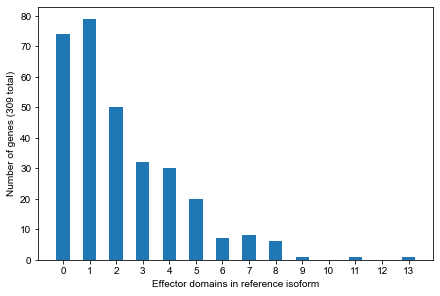

In [47]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain':
            c += 1
    return c

n_effector = [count_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1)
ax.hist(n_effector,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')

Text(0.5, 1.0, 'Soto et al. data')

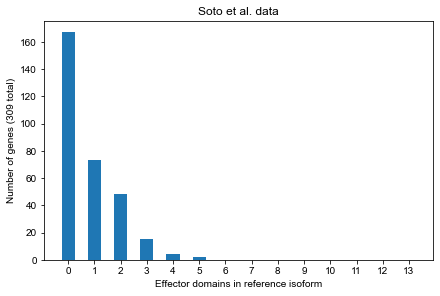

In [49]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Soto_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_soto = [count_Soto_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1)
ax.hist(n_effector_soto,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Soto et al. data')

Text(0.5, 1.0, 'Data from Bintu lab papers')

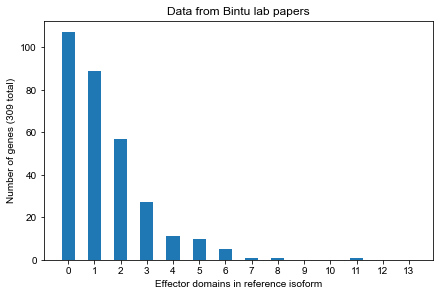

In [51]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Bintu_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and not d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_bintu = [count_Bintu_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1)
ax.hist(n_effector_bintu,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Data from Bintu lab papers')

In [76]:
# Summary stats
counter = {'Soto': 0,
           'Tycko': 0,
           'DelRosso': 0}
genes_with_effector = 0
genes_with_soto_effector = 0
for tf in tfs.values():
    has_effector = False
    has_soto_effector = False
    for dom in tf.cloned_reference_isoform.aa_seq_features:
        if dom.category == 'effector_domain':
            has_effector = True
            if dom.accession.startswith('Soto'):
                has_soto_effector = True
            counter[dom.accession.split('_')[0]] += 1
    if has_effector:
        genes_with_effector += 1
    if has_soto_effector:
        genes_with_soto_effector += 1
print(counter)
print(genes_with_effector, genes_with_soto_effector, len(tfs))

{'Soto': 240, 'Tycko': 52, 'DelRosso': 382}
235 142 309


In [66]:
counter = {'Soto': {'AD': 0, 'RD': 0, 'Bif': 0},
           'Tycko': {'AD': 0, 'RD': 0},
           'DelRosso': {'AD': 0, 'RD': 0}}
for tf in tfs.values():
    has_effector = False
    for dom in tf.cloned_reference_isoform.aa_seq_features:
        if dom.category == 'effector_domain':
            counter[dom.accession.split('_')[0]][dom.name] += 1
counter

{'Soto': {'AD': 156, 'RD': 80, 'Bif': 4},
 'Tycko': {'AD': 4, 'RD': 48},
 'DelRosso': {'AD': 37, 'RD': 345}}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


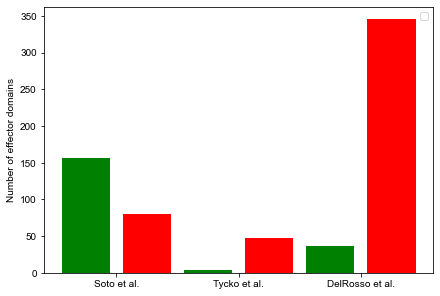

In [74]:
fig, ax = plt.subplots(1, 1)
ax.bar(x=range(6),
       height=[counter[x][y] for x in counter.keys() for y in ['AD', 'RD']],
       color=['green', 'red'] * 3)
ax.set_xticks([0.5, 2.5, 4.5])
ax.set_xticklabels(['Soto et al.', 'Tycko et al.', 'DelRosso et al.'])
ax.set_ylabel('Number of effector domains')

Text(0.5, 1.0, 'Tycko et al. + DelRosso et al.')

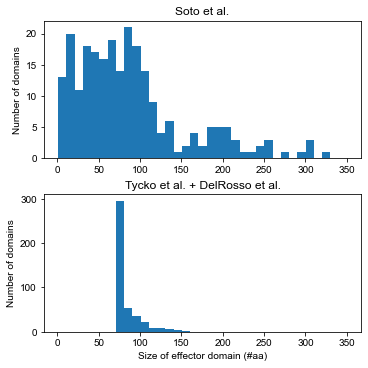

In [63]:
# length distribution of Soto vs Bintu lab domains
len_soto = []
len_bintu = []
for tf in tfs.values():
    for dom in tf.cloned_reference_isoform.aa_seq_features:
        if dom.category != 'effector_domain':
            continue
        if dom.accession.startswith('Soto'):
            len_soto.append(len(dom))
        else:
            len_bintu.append(len(dom))

fig, axs = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(h=5, w=5)
axs[0].hist(len_soto, range=(1, 350), bins=35)
axs[1].hist(len_bintu, range=(1, 350), bins=35)
axs[1].set_xlabel('Size of effector domain (#aa)')
for ax in axs:
    ax.set_ylabel('Number of domains')
axs[0].set_title('Soto et al.')
axs[1].set_title('Tycko et al. + DelRosso et al.')

In [ ]:
# compare activation and repression

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


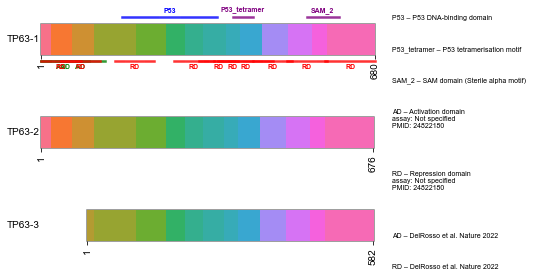

In [39]:
# look at tf with 13
list(tfs.values())[n_effector.index(13)].protein_diagram()

In [45]:
tfs['TP63']['TP63-1'].aa_seq_features[5].accession

'Soto_Effector 0778'

In [4]:
print('Effector domain types:')
dom['type'].value_counts()

Effector domain types:


RD     1796
AD      749
Bif      10
Name: type, dtype: int64

In [5]:
print('Effector domain types including Pfam:')
dom['type_incl_pfam'].value_counts()

Effector domain types including Pfam:


RD     1965
AD      789
Bif      10
Name: type_incl_pfam, dtype: int64

In [7]:
print('Number of different types of effector domains per gene')
dom.groupby('gene')['type'].nunique().value_counts().sort_index()

Number of different types of effector domains per gene


0     63
1    144
2     81
3      2
Name: type, dtype: int64

In [7]:
print('Number of different types of effector domains per gene including Pfam')
dom.groupby('gene')['type_incl_pfam'].nunique().value_counts()

Number of different types of effector domains per gene including Pfam


1    158
0     99
2     32
Name: type_incl_pfam, dtype: int64

In [8]:
(df.loc[df['activation_fold_change_log2'].notnull(),
        ['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed']]
    .notnull()
    .groupby(['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed'])
    .size())

fraction_of_AD_domains_removed  fraction_of_RD_domains_removed  fraction_of_Bif_domains_removed
False                           False                           False                              175
                                                                True                                 2
                                True                            False                               38
                                                                True                                 1
True                            False                           False                               66
                                                                True                                 3
                                True                            False                               42
dtype: int64

In [8]:
# color map
t_disorder = df.loc[:,'f_disorder_difference'].values
norm = plt.Normalize(np.nanmin(t_disorder), np.nanmax(t_disorder))
cmap = sns.color_palette("flare", as_cmap=True)
palette_disorder = {value: cmap(norm(value)) for value in t_disorder}

def re_color(row, palette):
    if pd.isnull(row['f_disorder_difference']):
        color = palette[0]
    else:
        color = palette[row['f_disorder_difference']]
    return color

df["color_disorder"] = df.apply(re_color, axis=1, palette=palette_disorder)

# set na f_disorder_difference to 0 for now
df["f_disorder_difference"].fillna(0, inplace=True)

In [85]:
# color map - length instead
# sum up lengths of all domains (plot only includes examples w 1 type of domain)
df['tot_dom_length'] = df[['length_of_AD_domains', 'length_of_RD_domains', 'length_of_Bif_domains']].sum(axis=1)
t_dom_length = df.loc[:,'tot_dom_length'].values
t_dom_length = t_dom_length[t_dom_length > 0]

# using min and max makes colors too hard too read - cut off
norm = plt.Normalize(25, 250)
palette_dom_length = {value: cmap(norm(value)) for value in t_dom_length}

def re_color2(row, palette):
    if row['tot_dom_length'] == 0:
        color = sns.color_palette("flare")[0]
    else:
        color = palette[row['tot_dom_length']]
    return color

df["color_dom_length"] = df.apply(re_color2, axis=1, palette=palette_dom_length)

In [86]:
# color map - length instead
# sum up lengths of all domains (plot only includes examples w 1 type of domain)
df['tot_dom_length_incl_pfam'] = df[['length_of_AD_domains_incl_pfam', 'length_of_RD_domains_incl_pfam', 'length_of_Bif_domains_incl_pfam']].sum(axis=1)
t_dom_length_incl_pfam = df.loc[:,'tot_dom_length_incl_pfam'].values
t_dom_length_incl_pfam = t_dom_length_incl_pfam[t_dom_length_incl_pfam > 0]

# using min and max makes colors too hard too read - cut off
norm = plt.Normalize(25, 250)
palette_dom_length_incl_pfam = {value: cmap(norm(value)) for value in t_dom_length_incl_pfam}

def re_color3(row, palette):
    if row['tot_dom_length_incl_pfam'] == 0:
        color = sns.color_palette("flare")[0]
    else:
        color = palette[row['tot_dom_length_incl_pfam']]
    return color

df["color_dom_length_incl_pfam"] = df.apply(re_color3, axis=1, palette=palette_dom_length_incl_pfam)
df.sample(5)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2,fraction_of_AD_domains_removed,insertion_in_AD_domains,length_of_AD_domains,fraction_of_RD_domains_removed,insertion_in_RD_domains,length_of_RD_domains,fraction_of_Bif_domains_removed,insertion_in_Bif_domains,length_of_Bif_domains,fraction_of_AD_domains_removed_incl_pfam,insertion_in_AD_domains_incl_pfam,length_of_AD_domains_incl_pfam,fraction_of_RD_domains_removed_incl_pfam,insertion_in_RD_domains_incl_pfam,length_of_RD_domains_incl_pfam,fraction_of_Bif_domains_removed_incl_pfam,insertion_in_Bif_domains_incl_pfam,length_of_Bif_domains_incl_pfam,tot_dom_length,color_dom_length,tot_dom_length_incl_pfam,color_dom_length_incl_pfam
291,SMAD3,ENSG00000166949,SMAD,True,SMAD3|1/4|06A07,SMAD3|2/4|06G07,ENST00000327367,NaN,False,True,True,425,381,9,8,False,False,True,False,False,True,False,False,0.0,0.0,False,89.4,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,NaN,retains all,retains all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.840369,1.086871,0.246502,SMAD3-1,SMAD3-2,0.636364,partially disordered,True,0.246502,0.000000,0.0,227.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,227.0,NaN,NaN,NaN,NaN,NaN,NaN,227.0,"(0.3866314, 0.16203977, 0.41508517, 1.0)",227.0,"(0.3866314, 0.16203977, 0.41508517, 1.0)"
382,ZNF230,ENSG00000159882,C2H2 ZF,False,ZNF230|1/2|10D07,ZNF230|2/2|10B07,ENST00000429154,ENST00000585632,False,False,True,474,87,4,3,False,True,False,True,False,False,False,False,0.0,100.0,True,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-2.133890,-1.537900,0.595990,ZNF230-1,ZNF230-2,0.201474,partially disordered,True,0.595990,NaN,NaN,NaN,0.05000,10.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,0.032787,10.0,122.0,NaN,NaN,NaN,80.0,"(0.89912041, 0.4510366, 0.37289175, 1.0)",122.0,"(0.81662276, 0.28668665, 0.38236999, 1.0)"
240,FOXJ2,ENSG00000065970,Forkhead,False,FOXJ2|1/2|06F10,FOXJ2|2/2|06B11,ENST00000162391,ENST00000428177,False,False,True,574,526,10,8,False,True,False,True,False,False,False,False,0.0,0.0,False,89.7,2.0,0.0,2.0,2.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,True,6.550576,1.167440,-5.383136,FOXJ2-1,FOXJ2-2,1.000000,fully disordered,True,5.383136,0.068421,0.0,190.0,NaN,NaN,NaN,NaN,NaN,NaN,0.068421,0.0,190.0,NaN,NaN,NaN,NaN,NaN,NaN,190.0,"(0.54221157, 0.19375869, 0.44233698, 1.0)",190.0,"(0.54221157, 0.19375869, 0.44233698, 1.0)"
115,HSF2,ENSG00000025156,HSF,True,HSF2|1/2|12B08,HSF2|2/2|09A10,ENST00000368455,ENST00000452194,False,False,True,536,518,13,12,False,False,True,False,False,True,False,False,0.0,0.0,False,96.6,2.0,2.0,2.0,2.0,2.0,2.0,1.000000,NaN,retains all,NaN,retains all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.058213,1.523062,0.464849,HSF2-1,HSF2-2,1.000000,fully disordered,True,0.464849,0.000000,0.0,152.0,0.03666,0.0,491.0,NaN,NaN,NaN,0.000000,0.0,152.0,0.036660,0.0,491.0,NaN,NaN,NaN,643.0,"(0.29408557, 0.13721193, 0.38442775, 1.0)",643.0,"

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: -0.3615497684072446, -1.099521718454925


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 37.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: 0.0, -4.185867921507783
found: 0.4, -1.3738165060156273


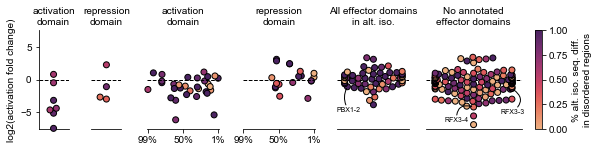

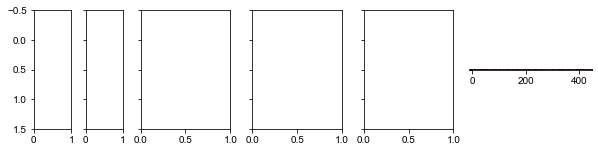

In [12]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_disorder
hue = 'f_disorder_difference'
color = 'color_disorder'
t = t_disorder

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed'] == 1) 
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                        & (df['fraction_of_Bif_domains_removed'].isnull() | 
                           (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed'] == 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed'] == 1) &
                          (df['fraction_of_RD_domains_removed'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed'] > 0) 
                & (df['fraction_of_AD_domains_removed'] < 1)
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed'] > 0)
                  &  (df['fraction_of_RD_domains_removed'] < 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                          (df['fraction_of_RD_domains_removed'] == 0) |
                          (df['fraction_of_Bif_domains_removed'] == 0))
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0)) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[5].set_xticks([])
axs[5].set_xlabel('')
axs[5].get_legend().remove()

# annotate RFX3-3
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[5].collections:
    for x, y in point.get_offsets():
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-3", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.7"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-4", xy=(x, y), xytext=(-5, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.7"), 
                            ha="right", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[5].imshow(np.stack([t, t]), cmap="flare")
fig.colorbar(map1, ax=axs[5], aspect=60, label="% alt. iso. seq. diff.\nin disordered regions")


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_colored_by_disorder.pdf', bbox_inches='tight')

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 36.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: -8.881784197001252e-16, -4.185867921507785
found: -0.17450218582933896, -1.373816506015629
found: -0.4, -1.099521718454925


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


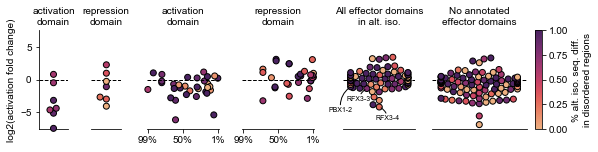

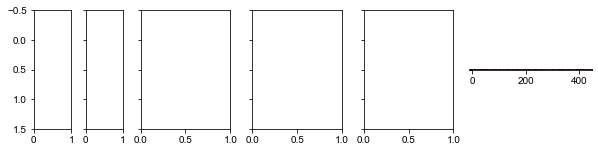

In [13]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_disorder
hue = 'f_disorder_difference'
color = 'color_disorder'
t = t_disorder

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) 
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                        & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed_incl_pfam'] == 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) &
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed_incl_pfam'] > 0) 
                & (df['fraction_of_AD_domains_removed_incl_pfam'] < 1)
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed_incl_pfam'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed_incl_pfam'] > 0)
                  &  (df['fraction_of_RD_domains_removed_incl_pfam'] < 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed_incl_pfam'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_AD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_RD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1 and rfx3
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(-10, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-3", xy=(x, y), xytext=(-8, -7), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-4", xy=(x, y), xytext=(8, -8), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed_incl_pfam"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed_incl_pfam"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed_incl_pfam"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[5].set_xticks([])
axs[5].set_xlabel('')
axs[5].get_legend().remove()


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[5].imshow(np.stack([t, t]), cmap="flare")
fig.colorbar(map1, ax=axs[5], aspect=60, label="% alt. iso. seq. diff.\nin disordered regions")


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_incl_pfam_colored_by_disorder.pdf', bbox_inches='tight')

In [14]:
tot_loss_repr[["gene_symbol", "clone_acc_ref", "clone_acc_alt", "f_disorder_difference", "color_disorder", 
               "activation_fold_change_log2"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,f_disorder_difference,color_disorder,activation_fold_change_log2
153,FOXP2,FOXP2|2/10|07B01,FOXP2|10/10|06A10,0.544776,"(0.71837612, 0.24102046, 0.41863486, 1.0)",2.235620
201,HHEX,HHEX|1/2|05H05,HHEX|2/2|05A04,0.837209,"(0.44212538, 0.17289906, 0.43031642, 1.0)",-1.091553
203,MXI1,MXI1|2/4|01D05,MXI1|3/4|01H03,0.305556,"(0.88217931, 0.38923439, 0.35995244, 1.0)",-2.975484
204,MXI1,MXI1|2/4|01D05,MXI1|4/4|02D05,0.239130,"(0.89995995, 0.45494253, 0.37420106, 1.0)",-2.675456
305,ZNF263,ZNF263|1/3|11C01,ZNF263|3/3|05A08,0.000000,"(0.92907237, 0.68878959, 0.50411509, 1.0)",-4.057763
312,ZFP1,ZFP1|2/4|04D02,ZFP1|4/4|04C01,0.379947,"(0.84916723, 0.32289973, 0.36711424, 1.0)",0.957208
315,ZSCAN32,ZSCAN32|1/5|05B06,ZSCAN32|2/5|05F05,0.000000,"(0.92907237, 0.68878959, 0.50411509, 1.0)",-0.282397


ValueError: Could not interpret input 'tot_dom_length'

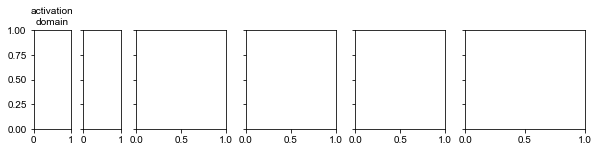

In [84]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_dom_length
hue = 'tot_dom_length'
color = 'color_dom_length'
t = t_dom_length

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed'] == 1) 
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                        & (df['fraction_of_Bif_domains_removed'].isnull() | 
                           (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed'] == 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed'] == 1) &
                          (df['fraction_of_RD_domains_removed'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed'] > 0) 
                & (df['fraction_of_AD_domains_removed'] < 1)
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed'] > 0)
                  &  (df['fraction_of_RD_domains_removed'] < 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                          (df['fraction_of_RD_domains_removed'] == 0) |
                          (df['fraction_of_Bif_domains_removed'] == 0))
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0)) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[5].set_xticks([])
axs[5].set_xlabel('')

# annotate RFX3-3
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[5].collections:
    for x, y in point.get_offsets():
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-3", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.7"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-4", xy=(x, y), xytext=(-5, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.7"), 
                            ha="right", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
            
# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[4].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[4], aspect=60, label="# AA in annotated domain")
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_colored_by_dom_length.pdf', bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: -8.881784197001252e-16, -4.185867921507783
found: 0.37028447362844474, -1.3738165060156264
found: -0.4, -1.0995217184549233


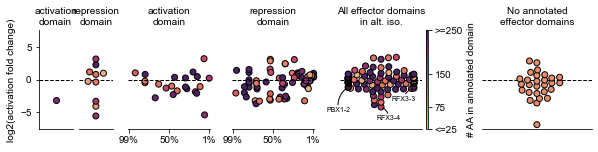

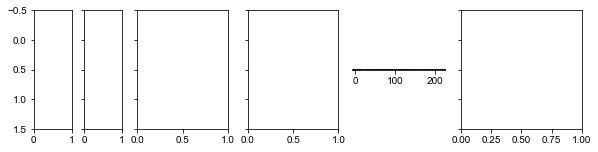

In [87]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_dom_length_incl_pfam
hue = 'tot_dom_length_incl_pfam'
color = 'color_dom_length_incl_pfam'
t = t_dom_length_incl_pfam

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) 
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                        & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed_incl_pfam'] == 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) &
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed_incl_pfam'] > 0) 
                & (df['fraction_of_AD_domains_removed_incl_pfam'] < 1)
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed_incl_pfam'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed_incl_pfam'] > 0)
                  &  (df['fraction_of_RD_domains_removed_incl_pfam'] < 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed_incl_pfam'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_AD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_RD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1 and rfx3
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(-10, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-3", xy=(x, y), xytext=(-8, -7), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-4", xy=(x, y), xytext=(8, -8), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = pd.concat([tot_loss_activ, 
                  tot_loss_repr, 
                  tot_loss_both, 
                  partial_loss_activ, 
                  partial_loss_repr, 
                  all_retained])

no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed_incl_pfam"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed_incl_pfam"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed_incl_pfam"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[5].set_xticks([])
axs[5].set_xlabel('')


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[4].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[4], aspect=60, label="# AA in annotated domain")
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_incl_pfam_colored_by_dom_length.pdf', bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 44.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: -8.881784197001252e-16, -4.185867921507784
found: -0.3368415198244641, -1.3738165060156273
found: -0.4, -1.099521718454925


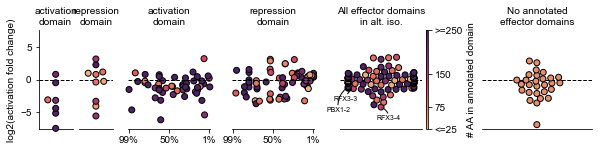

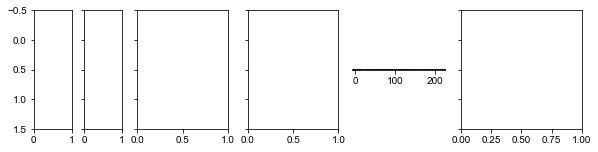

In [88]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_dom_length_incl_pfam
hue = 'tot_dom_length_incl_pfam'
color = 'color_dom_length_incl_pfam'
t = t_dom_length_incl_pfam

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed_incl_pfam'] == 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) &
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed_incl_pfam'] > 0) 
                & (df['fraction_of_AD_domains_removed_incl_pfam'] < 1)
                        ), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed_incl_pfam'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed_incl_pfam'] > 0)
                  &  (df['fraction_of_RD_domains_removed_incl_pfam'] < 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed_incl_pfam'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_AD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_RD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1 and rfx3
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(-10, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-3", xy=(x, y), xytext=(-8, -7), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-4", xy=(x, y), xytext=(8, -8), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = pd.concat([tot_loss_activ, 
                  tot_loss_repr, 
                  tot_loss_both, 
                  partial_loss_activ, 
                  partial_loss_repr, 
                  all_retained])

no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed_incl_pfam"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed_incl_pfam"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed_incl_pfam"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[5].set_xticks([])
axs[5].set_xlabel('')


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[4].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[4], aspect=60, label="# AA in annotated domain")
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_incl_pfam_colored_by_dom_length_lossen-requirements.pdf', bbox_inches='tight')

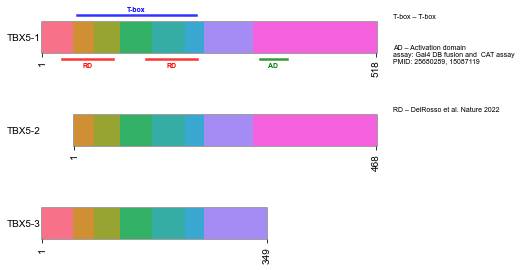

In [28]:
tfs['TBX5'].protein_diagram()

In [ ]:
for tf in tfs:
    

In [ ]:
# CHECK
# why is there only one full loss of activation domain (down from 7)?

# TODO
# fix proportions so that all points fit 

In [17]:
tot_loss_repr

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,insertion_in_RD_domains_incl_pfam,length_of_RD_domains_incl_pfam,fraction_of_Bif_domains_removed_incl_pfam,insertion_in_Bif_domains_incl_pfam,length_of_Bif_domains_incl_pfam,color_disorder,tot_dom_length,color_dom_length,tot_dom_length_incl_pfam,color_dom_length_incl_pfam
153,FOXP2,ENSG00000128573,Forkhead,False,FOXP2|2/10|07B01,FOXP2|10/10|06A10,ENST00000350908|ENST00000393494,ENST00000462331,False,False,...,0.0,85.0,NaN,NaN,NaN,"(0.71837612, 0.24102046, 0.41863486, 1.0)",85.0,"(0.89360794, 0.42764714, 0.36618273, 1.0)",85.0,"(0.89360794, 0.42764714, 0.36618273, 1.0)"
201,HHEX,ENSG00000152804,Homeodomain,False,HHEX|1/2|05H05,HHEX|2/2|05A04,ENST00000282728,ENST00000472590|ENST00000492654,False,False,...,0.0,111.0,NaN,NaN,NaN,"(0.44212538, 0.17289906, 0.43031642, 1.0)",185.0,"(0.56041794, 0.19845221, 0.44207535, 1.0)",185.0,"(0.56041794, 0.19845221, 0.44207535, 1.0)"
203,MXI1,ENSG00000119950,bHLH,True,MXI1|2/4|01D05,MXI1|3/4|01H03,ENST00000239007,ENST00000369612|ENST00000650644|ENST0000065069...,False,False,...,0.0,35.0,NaN,NaN,NaN,"(0.88217931, 0.38923439, 0.35995244, 1.0)",35.0,"(0.925747, 0.64722729, 0.47827244, 1.0)",35.0,"(0.925747, 0.64722729, 0.47827244, 1.0)"
204,MXI1,ENSG00000119950,bHLH,True,MXI1|2/4|01D05,MXI1|4/4|02D05,ENST00000239007,ENST00000361248|ENST00000652604,False,False,...,0.0,35.0,NaN,NaN,NaN,"(0.89995995, 0.45494253, 0.37420106, 1.0)",35.0,"(0.925747, 0.64722729, 0.47827244, 1.0)",35.0,"(0.925747, 0.64722729, 0.47827244, 1.0)"
305,ZNF263,ENSG00000006194,C2H2 ZF,False,ZNF263|1/3|11C01,ZNF263|3/3|05A08,ENST00000219069,ENST00000574253,False,False,...,0.0,40.0,NaN,NaN,NaN,"(0.92907237, 0.68878959, 0.50411509, 1.0)",0.0,"(0.9155979, 0.55210684, 0.42070204)",40.0,"(0.92354597, 0.62457749, 0.46433898, 1.0)"
312,ZFP1,ENSG00000184517,C2H2 ZF,False,ZFP1|2/4|04D02,ZFP1|4/4|04C01,ENST00000332307,ENST00000568079,False,False,...,0.0,15.0,NaN,NaN,NaN,"(0.84916723, 0.32289973, 0.36711424, 1.0)",0.0,"(0.9155979, 0.55210684, 0.42070204)",15.0,"(0.92907237, 0.68878959, 0.50411509, 1.0)"
315,ZSCAN32,ENSG00000140987,C2H2 ZF,False,ZSCAN32|1/5|05B06,ZSCAN32|2/5|05F05,ENST00000396852,NaN,False,True,...,0.0,35.0,NaN,NaN,NaN,"(0.92907237, 0.68878959, 0.50411509, 1.0)",0.0,"(0.9155979, 0.55210684, 0.42070204)",35.0,"(0.925747, 0.64722729, 0.47827244, 1.0)"


In [75]:
df[df["gene_symbol"] == "PBX1"][["gene_symbol", "clone_acc_ref", "clone_acc_alt", "fraction_of_AD_domains_removed",
                                 "fraction_of_RD_domains_removed", "fraction_of_Bif_domains_removed",
                                 "m1h_gte_2_fold_at_least_one_iso_per_gene",
                                 "activation_fold_change_log2"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,fraction_of_AD_domains_removed,fraction_of_RD_domains_removed,fraction_of_Bif_domains_removed,m1h_gte_2_fold_at_least_one_iso_per_gene,activation_fold_change_log2
20,PBX1,PBX1|1/2|02A05,PBX1|2/2|02C05,NaN,0.0,NaN,True,-1.099522


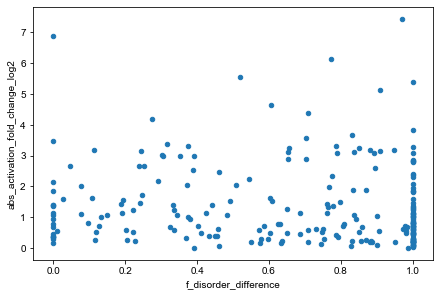

In [57]:
df.plot.scatter(x='f_disorder_difference', y='abs_activation_fold_change_log2')

In [36]:
x_var = 'f_disorder_difference'
y_var = 'activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.07470937141695498, 0.2529507103769628)
SpearmanrResult(correlation=0.1071481018046003, pvalue=0.10058356056724486)


In [37]:
x_var = 'f_disorder_difference'
y_var = 'abs_activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(-0.0837288170698881, 0.19995186764778164)
SpearmanrResult(correlation=-0.15538103718127458, pvalue=0.01690066916679032)


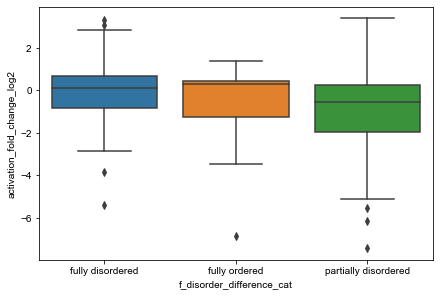

In [38]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='activation_fold_change_log2')

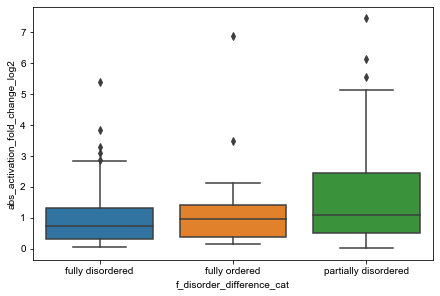

In [39]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='abs_activation_fold_change_log2')

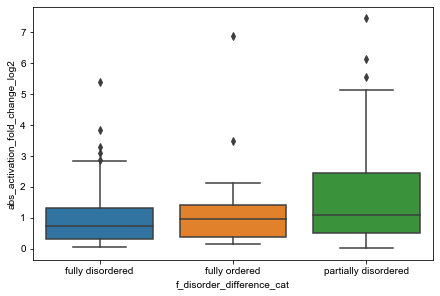

In [40]:
sns.boxplot(data=df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True), :],
            x='f_disorder_difference_cat',
            y='abs_activation_fold_change_log2')

In [41]:
stats.mannwhitneyu(
        df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully ordered'),
               'abs_activation_fold_change_log2'].values,
               df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully disordered')
               , 'abs_activation_fold_change_log2'].values
                          )

MannwhitneyuResult(statistic=659.0, pvalue=0.20674808462040722)

Interestingly, I don't see a difference between disordered and ordered changes and 
activation levels. Check for confounding factors like the size of the changes.

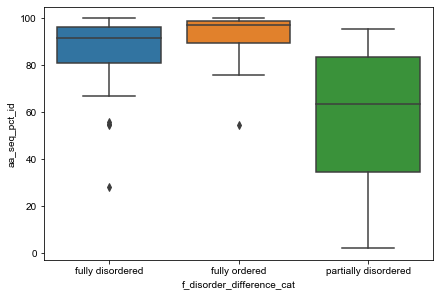

In [42]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='aa_seq_pct_id', 
            order=['fully disordered',
                   'fully ordered',
                   'partially disordered'])

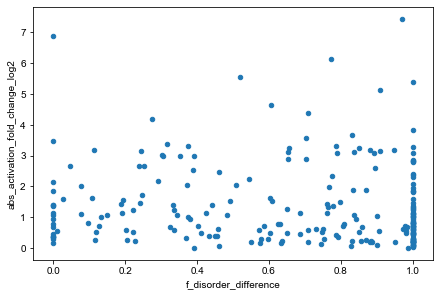

In [43]:
df.plot.scatter(x='f_disorder_difference', y='abs_activation_fold_change_log2')

In [44]:
# x axis as size of change (or aa %id), y axis as act diff, split by dis and ordered

In [45]:
# check examples
(df.loc[df['f_disorder_difference_cat'] == 'fully ordered',
         :]
         .sort_values('abs_activation_fold_change_log2',
                      ascending=False)).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2,fraction_of_AD_domains_removed,insertion_in_AD_domains,fraction_of_RD_domains_removed,insertion_in_RD_domains,fraction_of_Bif_domains_removed,insertion_in_Bif_domains
114,TBPL1,ENSG00000028839,TBP,False,TBPL1|1/2|04H06,TBPL1|2/2|04A07,ENST00000237264|ENST00000613034,ENST00000367871,False,False,...,0.0,fully ordered,True,6.864281,NaN,NaN,NaN,NaN,NaN,NaN
224,E2F8,ENSG00000129173,E2F,True,E2F8|1/4|03G03,E2F8|2/4|03A06,ENST00000250024|ENST00000527884|ENST00000620009,NaN,False,True,...,0.0,fully ordered,True,3.464671,NaN,NaN,NaN,NaN,NaN,NaN
332,MLX,ENSG00000108788,bHLH,True,MLX|1/4|11G02,MLX|2/4|01D12,ENST00000435881,NaN,False,True,...,0.0,fully ordered,True,2.129417,NaN,NaN,NaN,NaN,NaN,NaN
11,NFIA,ENSG00000162599,SMAD,True,NFIA|2/5|02G09,NFIA|3/5|02E09,ENST00000403491,ENST00000407417,False,False,...,0.0,fully ordered,True,1.845586,0.000000,0.0,0.0,0.0,NaN,NaN
260,TFCP2,ENSG00000135457,Grainyhead,True,TFCP2|1/3|03E08,TFCP2|2/3|03H07,ENST00000257915,NaN,False,True,...,0.0,fully ordered,True,1.401124,0.284916,0.0,0.0,0.0,NaN,NaN


In [46]:
df['f_disorder_difference_cat'].value_counts()

partially disordered    138
fully disordered         79
fully ordered            19
Name: f_disorder_difference_cat, dtype: int64

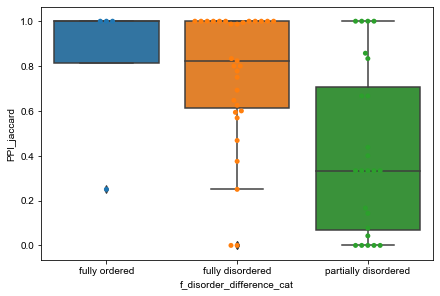

In [47]:
# TODO move PPI stuff to different notebook
sns.swarmplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')
sns.boxplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')

In [48]:
x = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully ordered'),
       'PPI_jaccard'].values
y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully disordered'),
       'PPI_jaccard'].values
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=45.0, pvalue=0.18826235330351887)

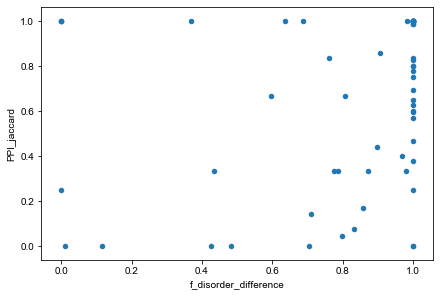

In [49]:
(df.loc[(df['n_positive_PPI_ref'] > 0) & 
        (df['n_positive_PPI_alt'] > 0), 
        :].plot.scatter(x='f_disorder_difference', y='PPI_jaccard'))

In [50]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.2167987760994965, 0.09908339031720248)
SpearmanrResult(correlation=0.2763824678991044, pvalue=0.03409237427596511)


In [51]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              (df['f_disorder_difference'] > 0) &
              (df['f_disorder_difference'] < 1) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.2825089068106956, 0.18104003872503516)
SpearmanrResult(correlation=0.3134951916946277, pvalue=0.13577250432041632)
